In [5]:
# Imports

import torch
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
import numpy as np
import gc
import pickle
import plotly.express as px
import plotly.graph_objects as go
import six
import os
import re
from tqdm import tqdm
import warnings
import dill
import random
import scipy

import hdbscan
from umap import UMAP
from umap.parametric_umap import ParametricUMAP
from sklearn.feature_extraction.text import CountVectorizer
import nltk

In [ ]:
desired_languages = ["und", "hr",  "cs",  "et",  "fi",  "fr",  "de",  "el",  "hu",  "it",  "lv",  "lt",  "pl",  "pt",  "ro",  "sk",  "sl",  "es"]
# Obtain dataframe
csv_collection = []
for dirname, _, filenames in os.walk('./Data/ukraine-russian-crisis-twitter-dataset-1-2-m-rows/'):
    for filename in filenames:
        fullpath= os.path.join(dirname, filename)
        csv_collection.append(fullpath)

df = pd.DataFrame()
for i, v in enumerate(tqdm(csv_collection)):
    #print(f"{i+1} out of {len(csv_collection)}")
    #print(v)
    tmp = pd.read_csv(v ,compression = 'gzip', index_col=0)[['tweetcreatedts', 'text','language']] # only keep important columns to lower memory consumption
    tmp = tmp.drop_duplicates(subset=['text']) # remove duplicates as most are retweets
    mask = tmp['language'].isin(desired_languages)
    #print(f"{len(tmp)} unique values in {i+1}th csv")
    tmp = tmp[mask]
    df = pd.concat([df, tmp], axis=0)

df.reset_index()
df.to_pickle('./Pickles/raw_df.pkl')

In [ ]:
raw_df = pd.read_pickle('./Pickles/raw_df.pkl')
raw_df.head()
raw_df['language'].unique(), len(raw_df)

**Randomly sampling Part of Dataset**

In [ ]:
idxs = np.random.choice(len(raw_df), int(np.ceil(0.75*len(raw_df))), replace=False)
df_small = raw_df.iloc[idxs]
df_small.to_pickle('./Pickles/df_small.pkl')

In [ ]:
df_small = pd.read_pickle('./Pickles/df_small.pkl')
df_small

**Plotting Language Distribution (todo: plotly)**

In [ ]:
g=sns.barplot(x=df_small.language.value_counts()[:].index,y=df_small.language.value_counts()[:])
g.set_yscale("log")

**Plotting Daily Tweet Count**

In [ ]:
df_dailycounts = pd.to_datetime(df_small['tweetcreatedts']).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count').sort_values(by='date')
fig = px.line(df_dailycounts, x='date', y="count")
fig.show()

**Random Example of some unprocessed tweets**

In [ ]:
for i in df_small.iloc[np.random.choice(len(df_small), 5)]['text']: print(f"{i}\n")

**Preprocessing Data and Translating**

In [ ]:
def preprocess_tweet(examples):
    text = examples['text']
    new_text = []
    text = re.sub('\n', ' ', str(text)) # replace new lines with space
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t # replace tags with "@user"
        t = 'http' if t.startswith(('http', 'www')) or t.endswith('.com') else t # replace links with "http"
        new_text.append(t)
    text = " ".join(new_text)   
    return dict(text = text)

In [ ]:
df_proc = pd.DataFrame(Dataset.from_pandas(df_small).map(preprocess_tweet))
df_proc.to_pickle('./Pickles/df_proc.pkl')
df_proc.head()

In [ ]:
df_proc = pd.read_pickle('./Pickles/df_proc.pkl')
df_proc

In [ ]:
# translating
from google.cloud import translate_v2 as translate
path = "/home/elyx/ukraine-twitter-NLP/cred.json" # path to google cloud api credentials json
translate_client = translate.Client.from_service_account_json(path)

def translate_text(examples):
    """Translates text into the target language"""
    target = 'EN'
    text = examples['text']
    
    result = translate_client.translate(text, target_language=target)
    
    return dict(text=[result[i]["translatedText"] for i in np.arange(len(result))],
                language=[result[i]['detectedSourceLanguage'] for i in np.arange(len(result))])

In [ ]:
df_trans = pd.DataFrame(Dataset.from_pandas(df_proc).map(translate_text, batched=True, batch_size=125))

mask = df_trans['language'].isin(desired_languages)
df_trans = df_trans[mask] # removing non desired languages that have been detected
df_trans = df_trans.reset_index()
df_trans['tweetcreatedts'] = pd.to_datetime(df_trans['tweetcreatedts']).dt.floor('d')

In [ ]:
# removing html codes
def html_remover(examples):
    text = examples['text']
    text = re.sub('&quot;', '"', str(text))
    text = re.sub('&#39;', "'", str(text))
    text = re.sub('&amp;', "&", str(text))
    return dict(text = text)

df_trans = pd.DataFrame(Dataset.from_pandas(df_trans).map(html_remover))
df_trans.to_pickle('./Pickles/df_trans.pkl')

In [ ]:
df_trans = pd.read_pickle('./Pickles/df_trans.pkl')
df_trans.shape, df_trans.columns

**Plotting new language distribution now that undetermined languages have been identified**

In [ ]:
language_counts = df_trans.groupby('language').size().sort_values(ascending=False).reset_index().rename(columns={0:'count'})
language_counts_mean = (df_trans.groupby('language').size() / 277).sort_values(ascending=False).reset_index().rename(columns={0:'count'})

fig = px.bar(language_counts, x='language', y='count',
             hover_data=['language', 'count'],
             template='seaborn',
             log_y=True,)


fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"y": [language_counts['count']]}],
                    label="Total",
                    method="update"
                ),
                dict(
                    args=[{"y": [language_counts_mean['count']]}],
                    label="Mean",
                    method="update"
                )
            ]),
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.0,
            xanchor="left",
            y=1.3,
            yanchor="top"
        ),
    ]
)

fig.show()
fig.write_html("./Plots/language_count.html")

**Removing languages that have average with less than 30 tweets a day (CLT)**

In [ ]:
final_languages = list(language_counts_mean.iloc[0:10].language)
mask = df_trans['language'].isin(final_languages)
df_trans = df_trans[mask]
df_trans = df_trans.reset_index(drop=True)
df_trans.to_pickle('./Pickles/df_trans.pkl')

In [110]:
df_trans = pd.read_pickle('./Pickles/df_trans.pkl')
df_trans.shape, df_trans.columns

((3712988, 5),
 Index(['index', 'tweetcreatedts', 'text', 'language', '__index_level_0__'], dtype='object'))

**Random Example of some processed tweets**

In [ ]:
for i in df_trans.iloc[np.random.choice(len(df_trans), 5)]['text']: print(f"{i}\n")

**Plotting daily tweet count by language over time**

In [118]:
df_dailycounts = df_trans.groupby(['language', 'tweetcreatedts']).size().unstack('language').reset_index().fillna(0)
df_dailycounts_norm = (df_dailycounts.iloc[:, 1:] / df_dailycounts.iloc[:, 1:].sum()).assign(tweetcreatedts=df_dailycounts['tweetcreatedts'])# divding every dayily count by the total number of tweets in that language

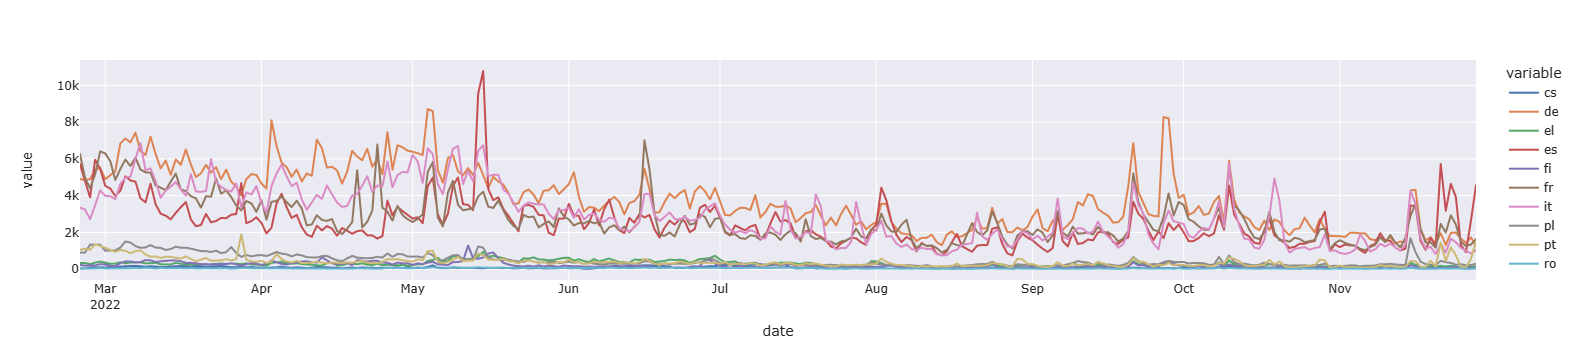

In [128]:
warnings.filterwarnings('ignore')
df_dailycounts.rename(columns={"tweetcreatedts":"date"}, inplace=True)
fig = go.Figure()
fig = px.line(df_dailycounts, x='date', y=df_dailycounts[["cs", "de", "el", "es", "fi", "fr", "it", "pl", "pt", "ro"]].columns,
              #hover_data={"tweetcreatedts": "|%B %d, %Y"},
              template='seaborn',)
              
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")

fig.update_layout(
    yaxis_title="Count",
    legend_title="language",
)
              
fig.show()
fig.write_html("./Plots/daily_tweets_per_language.html") # add button to normalize

**Word Cloud**

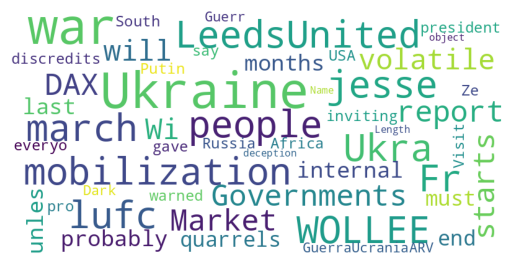

In [114]:
# word cloud on all languages
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stopwords_set = set(STOPWORDS)
stopwords_set.update(["user", "shows", "located", "dtype", "http", 'text']) # adding extra stop words

wordcloud = WordCloud(background_color='white',
                     stopwords = stopwords_set,
                      max_words = 300,
                      max_font_size = 40,
                      scale = 2,
                      random_state=42
                     ).generate(str(df_trans['text']))

plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./Plots/wordcloud.png')
plt.show()

**Extracting semantic tweet features using pretrained transformers**

In [78]:
df_trans = pd.read_pickle('./Pickles/df_trans.pkl')#.iloc[:100000]
df_trans.shape, df_trans.columns

((3712988, 5),
 Index(['index', 'tweetcreatedts', 'text', 'language', '__index_level_0__'], dtype='object'))

In [83]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2', device='cuda')#digio/Twitter4SSE
# get features in 2 batches because kernel keeps dying
def get_features(texts):
    arr_features = model.encode(texts, show_progress_bar=True)
    return arr_features
display(df_trans)
length = len(df_trans.index)
tweets_1 = df_trans.iloc[:int(length / 2)].text
tweets_2 = df_trans.drop(tweets_1.index).text

arr_features_1 = get_features(list(tweets_1))
np.save('./Pickles/arr_features_1', arr_features_1)
print("arr 1 saved")
arr_features_2 = get_features(list(tweets_2))
np.save('./Pickles/arr_features_2', arr_features_2)

,index,tweetcreatedts,text,language,__index_level_0__
0,0,2022-03-18,#jesse #march #LeedsUnited #WOLLEE #lufc #Ukra...,de,410968
1,2,2022-03-07,No mobilization from people in Fr? Governments...,fr,3438425
2,3,2022-03-18,Market report: DAX starts volatile into the Wi...,de,159704
3,5,2022-06-17,"@user The war will probably last months, unles...",el,110662
4,7,2022-05-31,"War in Ukraine: ""internal quarrels must end"", ...",fr,40020
...,...,...,...,...,...
3712983,5460315,2022-10-24,🔴 @user discredits himself by inviting pro #Ze...,fr,149939
3712984,5460316,2022-10-17,Visit to #South Africa by the president of #We...,it,112644
3712985,5460317,2022-03-20,@user #Putin can say: I warned and gave everyo...,de,408570
3712986,5460318,2022-08-08,#Russia #USA #Ukraine #GuerraUcraniaARV #Guerr...,es,52377


Batches: 100%|████████████████████████████████████████████████████████████████████| 58016/58016 [30:09<00:00, 32.06it/s]


arr 1 saved


Batches: 100%|████████████████████████████████████████████████████████████████████| 58016/58016 [30:01<00:00, 32.20it/s]


In [84]:
# combine two batches of features
arr_features_1 = np.load('./Pickles/arr_features_1.npy', allow_pickle=True)
print(arr_features_1.shape)
arr_features_2 = np.load('./Pickles/arr_features_2.npy', allow_pickle=True)
print(arr_features_2.shape)
arr_features = np.concatenate((arr_features_1, arr_features_2))
np.save('./Pickles/arr_features', arr_features)
print(arr_features.shape)

(1856494, 768)
(1856494, 768)
(3712988, 768)


In [2]:
arr_features = np.load('./Pickles/arr_features.npy', allow_pickle=True)
print(arr_features.shape)

(3712988, 768)


In [26]:
#arr_features = arr_features[:5000]
arr_features.shape

(10000, 768)

In [6]:
df_trans = pd.read_pickle('./Pickles/df_trans.pkl')
df_trans.shape

(3712988, 5)

**Umap, clustering, and topic modelling**

**Umap to high dimensions for clustering**

In [4]:
index = np.sort(np.random.choice(len(arr_features), 120000))
np.save('./Pickles/index', index)

In [5]:
warnings.filterwarnings('ignore')
index = np.load('./Pickles/index.npy', allow_pickle=True)

obj = ParametricUMAP(n_neighbors=20,
                            n_components=20,
                            min_dist=0,
                            metric='cosine',
                            #low_memory=True,
                            verbose=True)
obj.fit(arr_features[index])
umap_highdim_embeddings = obj.transform(arr_features)#[index])
np.save('./Pickles/umap_highdim_embeddings', umap_highdim_embeddings)
print(umap_highdim_embeddings.shape)

2022-12-18 03:37:48.816597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-18 03:37:48.817112: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-12-18 03:37:48.817218: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2022-12-18 03:37:48.817287: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-12-18 03:37:48.817412: W tensorflow/co

ParametricUMAP(optimizer=<keras.optimizers.optimizer_experimental.adam.Adam object at 0x7f84885de340>)
Sun Dec 18 03:37:53 2022 Construct fuzzy simplicial set
Sun Dec 18 03:37:54 2022 Finding Nearest Neighbors
Sun Dec 18 03:37:54 2022 Building RP forest with 22 trees
Sun Dec 18 03:38:04 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	Stopping threshold met -- exiting after 6 iterations
Sun Dec 18 03:38:27 2022 Finished Nearest Neighbor Search
Sun Dec 18 03:38:31 2022 Construct embedding


2022-12-18 03:39:43.124976: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1510465616 exceeds 10% of free system memory.
2022-12-18 03:39:44.488601: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1510465616 exceeds 10% of free system memory.
2022-12-18 03:39:56.664552: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1510465616 exceeds 10% of free system memory.
2022-12-18 03:39:57.091754: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1510465616 exceeds 10% of free system memory.
2022-12-18 03:39:59.047559: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 368640000 exceeds 10% of free system memory.


Epoch 1/10
18880/18880 [==============================] - 183s 9ms/step - loss: 0.2219
Epoch 2/10
18880/18880 [==============================] - 170s 9ms/step - loss: 0.2067
Epoch 3/10
18880/18880 [==============================] - 170s 9ms/step - loss: 0.2035
Epoch 4/10
18880/18880 [==============================] - 170s 9ms/step - loss: 0.2019
Epoch 5/10
18880/18880 [==============================] - 170s 9ms/step - loss: 0.2007
Epoch 6/10
18880/18880 [==============================] - 171s 9ms/step - loss: 0.2000
Epoch 7/10
18880/18880 [==============================] - 170s 9ms/step - loss: 0.1993
Epoch 8/10
18880/18880 [==============================] - 170s 9ms/step - loss: 0.1988
Epoch 9/10
18880/18880 [==============================] - 170s 9ms/step - loss: 0.1984
Epoch 10/10
3750/3750 [==============================] - 4s 1ms/step
Sun Dec 18 04:08:58 2022 Finished embedding
3713/3713 [==============================] - 10s 3ms/step
(3712988, 20)


In [2]:
umap_highdim_embeddings = np.load('./Pickles/umap_highdim_embeddings.npy', allow_pickle=True)
umap_highdim_embeddings.shape

(3712988, 20)

**Umap to low dimensions for plotting**

In [6]:
warnings.filterwarnings('ignore')
index = np.load('./Pickles/index.npy', allow_pickle=True)
obj = ParametricUMAP(n_neighbors=20,
                            n_components=2,
                            min_dist=0.5,
                            metric='cosine',
                            low_memory=True,
                            verbose=True)
obj.fit(umap_highdim_embeddings[index])
umap_embeddings = obj.transform(umap_highdim_embeddings)

np.save('./Pickles/umap_embeddings', np.array(umap_embeddings))

ParametricUMAP(optimizer=<keras.optimizers.optimizer_experimental.adam.Adam object at 0x7f84885a6d60>)
Sun Dec 18 04:11:04 2022 Construct fuzzy simplicial set
Sun Dec 18 04:11:04 2022 Finding Nearest Neighbors
Sun Dec 18 04:11:04 2022 Building RP forest with 22 trees
Sun Dec 18 04:11:05 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Sun Dec 18 04:11:10 2022 Finished Nearest Neighbor Search
Sun Dec 18 04:11:11 2022 Construct embedding
Epoch 1/10
15785/15785 [==============================] - 81s 5ms/step - loss: 0.0292
Epoch 2/10
15785/15785 [==============================] - 77s 5ms/step - loss: 0.0244
Epoch 3/10
15785/15785 [==============================] - 76s 5ms/step - loss: 0.0239
Epoch 4/10
15785/15785 [==============================] - 76s 5ms/step - loss: 0.0236
Epoch 5/10
15785/15785 [==============================] - 76s 5ms/step - loss: 0.0234
Epoch 6/10
15785/15785 [==============================] - 76s 5ms/ste

In [3]:
warnings.filterwarnings('ignore')
index = np.load('./Pickles/index.npy', allow_pickle=True)
obj = ParametricUMAP(n_neighbors=20,
                            n_components=3,
                            min_dist=0.5,
                            metric='cosine',
                            low_memory=True,
                            verbose=True)
obj.fit(umap_highdim_embeddings[index])
umap_embeddings_3d = obj.transform(umap_highdim_embeddings)

np.save('./Pickles/umap_embeddings_3d', np.array(umap_embeddings_3d))

2022-12-18 04:31:42.554088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-18 04:31:42.554449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-12-18 04:31:42.554532: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2022-12-18 04:31:42.554592: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-12-18 04:31:42.554649: W tensorflow/co

ParametricUMAP(optimizer=<keras.optimizers.optimizer_experimental.adam.Adam object at 0x7f4bad3b7b50>)
Sun Dec 18 04:31:42 2022 Construct fuzzy simplicial set
Sun Dec 18 04:31:42 2022 Finding Nearest Neighbors
Sun Dec 18 04:31:42 2022 Building RP forest with 22 trees
Sun Dec 18 04:31:43 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Sun Dec 18 04:31:57 2022 Finished Nearest Neighbor Search
Sun Dec 18 04:32:00 2022 Construct embedding
Epoch 1/10
15784/15784 [==============================] - 78s 5ms/step - loss: 0.0227
Epoch 2/10
15784/15784 [==============================] - 77s 5ms/step - loss: 0.0197
Epoch 3/10
15784/15784 [==============================] - 77s 5ms/step - loss: 0.0193
Epoch 4/10
15784/15784 [==============================] - 77s 5ms/step - loss: 0.0191
Epoch 5/10
15784/15784 [==============================] - 75s 5ms/step - loss: 0.0189
Epoch 6/10
15784/15784 [==============================] - 76s 5ms/ste

In [5]:
df_trans = pd.read_pickle('./Pickles/df_trans.pkl')
index = np.load('./Pickles/index.npy', allow_pickle=True)
umap_embeddings = np.load('./Pickles/umap_embeddings.npy', allow_pickle=True)
umap_embeddings_3d = np.load('./Pickles/umap_embeddings_3d.npy', allow_pickle=True)
#df_trans = df_trans.iloc[index]
print(df_trans.shape)
df_cluster = df_trans.assign(x=umap_embeddings[:, 0],y=umap_embeddings[:, 1], x3d=umap_embeddings_3d[:, 0], y3d=umap_embeddings_3d[:, 1], z3d=umap_embeddings_3d[:, 2])
df_cluster.to_pickle('./Pickles/df_cluster.pkl')
df_cluster

(3712988, 5)


,index,tweetcreatedts,text,language,__index_level_0__,x,y,x3d,y3d,z3d
0,0,2022-03-18,#jesse #march #LeedsUnited #WOLLEE #lufc #Ukra...,de,410968,16.180822,-0.948379,10.178366,5.090573,-0.397415
1,2,2022-03-07,No mobilization from people in Fr? Governments...,fr,3438425,1.641783,-3.954868,-0.919398,-0.365440,-3.401724
2,3,2022-03-18,Market report: DAX starts volatile into the Wi...,de,159704,-19.420137,-14.488963,-10.656095,-15.351851,0.883402
3,5,2022-06-17,"@user The war will probably last months, unles...",el,110662,2.569003,-8.344250,0.975848,-2.927543,-6.028432
4,7,2022-05-31,"War in Ukraine: ""internal quarrels must end"", ...",fr,40020,4.606858,6.875360,-0.500283,-1.458787,2.667216
...,...,...,...,...,...,...,...,...,...,...
3712983,5460315,2022-10-24,🔴 @user discredits himself by inviting pro #Ze...,fr,149939,7.671902,8.947151,0.461137,-0.359853,5.580214
3712984,5460316,2022-10-17,Visit to #South Africa by the president of #We...,it,112644,-11.391136,-6.535594,-9.418825,-5.578727,-0.857306
3712985,5460317,2022-03-20,@user #Putin can say: I warned and gave everyo...,de,408570,1.185582,-10.088500,0.509212,-5.296772,-5.385360
3712986,5460318,2022-08-08,#Russia #USA #Ukraine #GuerraUcraniaARV #Guerr...,es,52377,-31.391142,-22.503122,-13.866154,-5.554550,-21.528229


**Hdbscan clustering to find topics**

In [2]:
umap_highdim_embeddings = np.load('./Pickles/umap_highdim_embeddings.npy', allow_pickle=True)
df_cluster = pd.read_pickle('./Pickles/df_cluster.pkl')

In [3]:
from joblib import Memory
warnings.filterwarnings('ignore')
cluster = hdbscan.HDBSCAN(min_cluster_size=300,
                          #min_samples=55,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          memory='/tmp/joblib',
                          core_dist_n_jobs=-1,
                          #prediction_data=True,
                         ).fit(umap_highdim_embeddings)
df_cluster_topics = df_cluster.assign(topic=cluster.labels_)
print(f"{len(np.unique(cluster.labels_))} topics found")
df_cluster_topics
df_cluster_topics.to_pickle('./Pickles/df_cluster_topics.pkl')
#save model
#with open('./Pickles/hdbscan.pkl', 'wb') as inp:
#    dill.dump(cluster, inp)
df_cluster_topics

114 topics found


,index,tweetcreatedts,text,language,__index_level_0__,x,y,x3d,y3d,z3d,topic
0,0,2022-03-18,#jesse #march #LeedsUnited #WOLLEE #lufc #Ukra...,de,410968,16.180822,-0.948379,10.178366,5.090573,-0.397415,-1
1,2,2022-03-07,No mobilization from people in Fr? Governments...,fr,3438425,1.641783,-3.954868,-0.919398,-0.365440,-3.401724,-1
2,3,2022-03-18,Market report: DAX starts volatile into the Wi...,de,159704,-19.420137,-14.488963,-10.656095,-15.351851,0.883402,33
3,5,2022-06-17,"@user The war will probably last months, unles...",el,110662,2.569003,-8.344250,0.975848,-2.927543,-6.028432,-1
4,7,2022-05-31,"War in Ukraine: ""internal quarrels must end"", ...",fr,40020,4.606858,6.875360,-0.500283,-1.458787,2.667216,28
...,...,...,...,...,...,...,...,...,...,...,...
3712983,5460315,2022-10-24,🔴 @user discredits himself by inviting pro #Ze...,fr,149939,7.671902,8.947151,0.461137,-0.359853,5.580214,28
3712984,5460316,2022-10-17,Visit to #South Africa by the president of #We...,it,112644,-11.391136,-6.535594,-9.418825,-5.578727,-0.857306,32
3712985,5460317,2022-03-20,@user #Putin can say: I warned and gave everyo...,de,408570,1.185582,-10.088500,0.509212,-5.296772,-5.385360,-1
3712986,5460318,2022-08-08,#Russia #USA #Ukraine #GuerraUcraniaARV #Guerr...,es,52377,-31.391142,-22.503122,-13.866154,-5.554550,-21.528229,7


**TF-IDF to find important locally unique words per topic**

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import STOPWORDS

df_cluster_topics = pd.read_pickle('./Pickles/df_cluster_topics.pkl')
df_per_topic = df_cluster_topics.groupby(['topic'], as_index = False).agg(({'text': ' '.join})) #create a dataframe organized by topic with all tweets in a topic concatenated
stopwords_set = set(STOPWORDS)
stopwords_set.update(["user", "http", "located", "dtype", "actually", "quot", 'text', '39', 'according', 'got']) # adding extra stop words
stopwords_set=list(stopwords_set)
tfidf = TfidfVectorizer(stop_words=stopwords_set)
X = tfidf.fit_transform(df_per_topic['text']) # fits  tfidf on entire corpus of tweets
feature_names = tfidf.get_feature_names_out()

def get_top_tf_idf_words(response, top_n=2): # function that returns top words given tweets in a specific topic
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_names[response.indices[sorted_nzs]]

arr_tf_idf = []
for i in np.arange(len(df_per_topic)):
    responses = tfidf.transform([df_per_topic['text'][i]])
    arr_tf_idf.append(list(get_top_tf_idf_words(responses,15))) # adds tf_idfs to per topic dataframe

topic_tf_idf = dict(zip(np.arange(-1, len(df_per_topic)), arr_tf_idf))
df_cluster_topics.sort_values(by='topic', inplace=True)
topic_order = np.array(df_cluster_topics['topic'])
df_cluster_topics['tf_idf'] = [topic_tf_idf[i] for i in topic_order]
legend = dict(zip(np.arange(-1,len(df_per_topic)), [str(list(topic_tf_idf.keys())[i+1])+'_'+'_'.join(topic_tf_idf[i][0:5])[0:65] for i in np.arange(-1, len(topic_tf_idf) - 1)]))
df_cluster_topics['legend'] = [legend[i] for i in topic_order]

df_cluster_topics.to_pickle('./Pickles/df_cluster_topics.pkl')
df_cluster_topics

,index,tweetcreatedts,text,language,__index_level_0__,x,y,x3d,y3d,z3d,topic,tf_idf,legend
0,0,2022-03-18,#jesse #march #LeedsUnited #WOLLEE #lufc #Ukra...,de,410968,16.180822,-0.948379,10.178366,5.090573,-0.397415,-1,"[ukraine, russia, putin, war, russian, will, n...",-1_ukraine_russia_putin_war_russian
2039265,2999390,2022-04-20,"@user @user @user @user It's bitter, history w...",de,370349,4.713418,0.334463,0.491996,3.478414,-1.772871,-1,"[ukraine, russia, putin, war, russian, will, n...",-1_ukraine_russia_putin_war_russian
2039266,2999391,2022-05-09,"Calling him a ""fascist"", #Russia 🇷🇺 ambassador...",es,306014,15.000565,3.502066,7.304187,6.179469,2.628514,-1,"[ukraine, russia, putin, war, russian, will, n...",-1_ukraine_russia_putin_war_russian
2039268,2999393,2022-10-31,#Russia|s attacks on civilian infrastructure i...,de,69355,12.251215,1.508863,6.060304,5.391949,0.213335,-1,"[ukraine, russia, putin, war, russian, will, n...",-1_ukraine_russia_putin_war_russian
2039272,2999398,2022-05-01,@user Was it also the fresh air that told you ...,de,230648,-1.077417,-1.843023,-4.266979,2.226045,-5.031525,-1,"[ukraine, russia, putin, war, russian, will, n...",-1_ukraine_russia_putin_war_russian
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2230850,3280903,2022-07-11,This #help is not a toy for partisan politics....,de,45277,-1.785124,-9.765546,-0.782017,-7.853687,-0.823916,112,"[ukraine, germany, weapons, german, tanks, del...",112_ukraine_germany_weapons_german_tanks
651259,957592,2022-10-27,.@GresselGustav : In Europe there is the #Leop...,de,146054,2.513437,-14.136980,3.189590,-8.958196,-1.791999,112,"[ukraine, germany, weapons, german, tanks, del...",112_ukraine_germany_weapons_german_tanks
2180792,3207514,2022-03-10,"Panzerfausts, anti-aircraft missiles, armored ...",de,4669580,2.322790,-13.956409,3.035099,-8.914192,-1.644976,112,"[ukraine, germany, weapons, german, tanks, del...",112_ukraine_germany_weapons_german_tanks
3704232,5447305,2022-05-26,The #SPD justifies the refusal to send German ...,de,157703,-2.192203,-9.737432,-1.081040,-8.104433,-0.895615,112,"[ukraine, germany, weapons, german, tanks, del...",112_ukraine_germany_weapons_german_tanks


**Interactive Scatter Plot with Plotly**

In [2]:
index = np.load('./Pickles/index.npy', allow_pickle=True)
df_cluster_topics = pd.read_pickle('./Pickles/df_cluster_topics.pkl')
df_cluster_topics_ = df_cluster_topics.iloc[index]
clusters_only = np.where(df_cluster_topics_.topic != -1)[0]
print(clusters_only.shape)
#rand_idxs = np.random.choice(len(df_cluster_topics.iloc[clusters_only]), 80000, replace=False) # randomly pick 80000 points for file size purposes

df_cluster_plotting = df_cluster_topics.iloc[clusters_only].reset_index()#.iloc[rand_idxs]
df_cluster_plotting.to_pickle('./Pickles/df_cluster_plotting.pkl')
df_cluster_plotting.shape

(62262,)


(62262, 14)

In [ ]:
df_cluster_plotting = pd.read_pickle('./Pickles/df_cluster_plotting.pkl')

In [7]:
import plotly.express as px
fig = px.scatter(
    df_cluster_plotting,
    x='x',
    y='y',
    custom_data=['text', 'tf_idf', 'topic'],
    color='legend',#[str(i) for i in df_cluster_no_outlier.topic],
    width=1600, height=1000,
    template='seaborn',
)
# hover text style
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=11,
        font_family="Times New Roman"
    )
)

# hover data
fig.update_traces(
    hovertemplate="<br>".join([
        "%{customdata[0]}",
        "Topic %{customdata[2]} Keywords: %{customdata[1]}<extra></extra>",
    ])
)

# title
fig.update_layout(
    title={
        'text': "<b>Tweets by Topic 2D"})

# point size
fig.update_traces(marker={'size': 2})
fig.write_html("./Plots/tweet_by_topic_map.html")


In [12]:
# 3d plot
rand_idxs = np.random.choice(len(df_cluster_plotting), 2000, replace=False)
import plotly.express as px
fig = px.scatter_3d(
    df_cluster_plotting.iloc[rand_idxs],
    x='x3d',
    y='y3d',
    z='z3d',
    custom_data=['text', 'tf_idf', 'topic'],
    color='legend',
    width=1600, height=1000,
    template='seaborn',
)
# hover text style
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=11,
        font_family="Times New Roman"
    )
)

# hover data
fig.update_traces(
    hovertemplate="<br>".join([
        "%{customdata[0]}",
        "Topic %{customdata[2]} Keywords: %{customdata[1]}<extra></extra>",
    ])
)

# title
fig.update_layout(
    title={
        'text': "<b>Tweets by Topic 3D"})

# point size
fig.update_traces(marker={'size': 2})
fig.write_html("./Plots/tweet_by_topic_map_3d.html")


**Nordstream Pipeline Data**

In [27]:
# setting up nordstream datafarame
nordstream = pd.read_csv('Data/Nordstream/Nordstream daily.csv').iloc[54:]
nordstream['Date'] = pd.to_datetime(nordstream['Date'], dayfirst=True)
nordstream.rename(columns={"Nomination,kWh/day":"kWh/day"}, inplace=True)
nordstream.reset_index(drop=True, inplace=True)
fig = px.line(nordstream, x='Date', y="kWh/day")
fig.write_html('./Plots/nordstream_lineplot.html')
nordstream



,Date,kWh/day
0,2022-02-24,1.754037e+09
1,2022-02-25,1.752441e+09
2,2022-02-26,1.761598e+09
3,2022-02-27,1.755948e+09
4,2022-02-28,1.756104e+09
...,...,...
273,2022-11-24,0.000000e+00
274,2022-11-25,0.000000e+00
275,2022-11-26,0.000000e+00
276,2022-11-27,0.000000e+00


**Plotting total daily tweet counts with nordstream pipeline data**

In [112]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
 
df_dailycounts = pd.to_datetime(df_trans['tweetcreatedts']).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count').sort_values(by='date')

fig = make_subplots(specs=[[{"secondary_y": True}]])
 
# plot a scatter chart by specifying the x and y values
# Use add_trace function to specify secondary_y axes.
fig.add_trace(
    go.Scatter(x=df_dailycounts['date'], y=df_dailycounts['count'], name='daily tweet count'),
    secondary_y=False)
 
# Use add_trace function and specify secondary_y axes = True.
fig.add_trace(
    go.Scatter(x=nordstream['Date'], y=nordstream['kWh/day'], name='nordstream flow'),
    secondary_y=True,)
 
 
# Naming x-axis
fig.update_xaxes(title_text="Date")
 
# Naming y-axes
fig.update_yaxes(title_text="<b>Tweet Count</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>kWh/hr</b>", secondary_y=True)
fig.write_html('./Plots/Daily_tweet_count_with_nordstream.html')

**Analysis of topics**

In [93]:
df_cluster_topics = pd.read_pickle('./Pickles/df_cluster_topics.pkl')

In [94]:
topics = [12, 13, 14, 16, 18, 19, 22, 25, 26, 27, 28, 33, 41, 42, 46, 63, 66, 69, 73, 75, 76, 77, 79, 85, 86, 88, 92, 95, 107, 108, 109, 110, 111, 112]
languages = df_cluster_topics.language.unique()

**Plotting topic counts**

In [111]:
legend = df_cluster_topics.legend.unique()[1:]
df_topic_counts = df_cluster_topics.groupby(['topic']).size().iloc[1:].sort_values(ascending=False).to_frame().rename(columns={0:"count"}).reset_index()
mask = df_topic_counts.topic.isin(topics)
df_topic_counts['legend'] = legend[df_topic_counts['topic']]
df_topic_counts['topic'] = df_topic_counts['topic'].apply(str)
df_topic_counts = df_topic_counts[mask]

fig = px.bar(df_topic_counts, x='topic', y='count',
             hover_data=['count', 'legend'],
             template='seaborn',
             log_y=True,)
fig.write_html('./Plots/topic_counts.html')

**Creating dataframe with ratio of topic by day by country by topic**

In [96]:
df_tweet_bytopic_bylanguage = df_cluster_topics.groupby(['language', 'tweetcreatedts', 'topic'], dropna=False).size().reset_index().fillna(0).rename(columns={0:'count'})#.unstack('language')
df_tweet_bytopic_bylanguage.rename(columns={"tweetcreatedts":"Date"}, inplace=True)

#only selecting desired topics
mask = df_tweet_bytopic_bylanguage.topic.isin(topics)
df_tweet_bytopic_bylanguage = df_tweet_bytopic_bylanguage[mask]

# Normalising by dividing by total count over day per language
df_tweet_byday_bylanguage = df_cluster_topics.groupby(['tweetcreatedts', 'language']).size().reset_index().fillna(0).rename(columns={0:'count'})
df_tweet_byday_bylanguage.sort_values(['language', 'tweetcreatedts'])
df_tweet_byday_bylanguage.rename(columns={"tweetcreatedts":"Date", "count":"total_per_day"}, inplace=True)

df_tweet_bytopic_bylanguage = df_tweet_bytopic_bylanguage.sort_values(['language', 'Date']).reset_index(drop=True)
total_count_perday_perlanguage = df_tweet_bytopic_bylanguage.merge(df_tweet_byday_bylanguage, on=['language', 'Date']).sort_values(['language', 'Date']).total_per_day # merge because some days are null
df_tweet_bytopic_bylanguage['count'] = df_tweet_bytopic_bylanguage['count'] / total_count_perday_perlanguage

df_tweet_bytopic_bylanguage.rename(columns={"count":"ratio_of_topic"},inplace=True)
df_tweet_bytopic_bylanguage = pd.merge(df_tweet_bytopic_bylanguage, nordstream, on='Date')
df_tweet_bytopic_bylanguage

,language,Date,topic,ratio_of_topic,kWh/day
0,cs,2022-02-24,19,0.021277,1.754037e+09
1,cs,2022-02-24,28,0.021277,1.754037e+09
2,cs,2022-02-24,41,0.127660,1.754037e+09
3,cs,2022-02-24,69,0.042553,1.754037e+09
4,cs,2022-02-24,79,0.021277,1.754037e+09
...,...,...,...,...,...
62054,ro,2022-11-28,33,0.026316,0.000000e+00
62055,ro,2022-11-28,77,0.026316,0.000000e+00
62056,ro,2022-11-28,79,0.026316,0.000000e+00
62057,ro,2022-11-28,86,0.026316,0.000000e+00


**Find R^2 for every combination of Language and Topic and Plot as Heatmap**

In [97]:
df_r_squared = pd.DataFrame()
df_slope = pd.DataFrame()
df_p_value = pd.DataFrame()
legend = df_cluster_topics.legend.unique()
for t in topics:
    for l in languages:
        arr = df_tweet_bytopic_bylanguage.query(f"language == '{l}' and topic == {t}")
        try:
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(arr.ratio_of_topic, arr['kWh/day'])
            r_squared = r_value**2
        except: # if empty
            r_squared, slope, p_value = None, None, None
            
        topic = str(t)
        df_r_squared.loc[l, topic] = r_squared
        df_slope.loc[l, topic] = slope
        df_p_value.loc[l, topic] = p_value

In [108]:
legend_array = np.array(legend)[np.array(topics) + 1]
legend_array = np.tile(legend_array, (10, 1)).astype(str)
legend_array = np.core.defchararray.add('Topic: ', np.core.defchararray.add(legend_array, '<br>'))
#legend_array

In [109]:
r2_str = np.core.defchararray.add(np.core.defchararray.add('R Squared = ', np.around(df_r_squared.values, 5).astype(str)), '<br>')
slope_str = np.core.defchararray.add(np.core.defchararray.add('Slope = ', np.around(df_slope.values, 5).astype(str)), '<br>')
pval_str = np.core.defchararray.add('P Value = ', np.around(df_p_value.values, 15).astype(str))
text = np.core.defchararray.add(np.core.defchararray.add(r2_str, slope_str), pval_str)
text = np.core.defchararray.add(legend_array, text)

In [110]:
import plotly.graph_objects as go


fig = go.Figure(data=go.Heatmap(
    x=df_r_squared.columns,
    y=df_r_squared.index,
    z=df_r_squared.values.tolist(),
    text=text,
    texttemplate="",
    hoverongaps = False,
))

fig.update_layout(
    xaxis_title="topic",
    yaxis_title="language",
    legend_title="R Squared Value",
)

fig.write_html('./Plots/r_squared_heatmap.html')

**Plot most interesting topics as line plots**

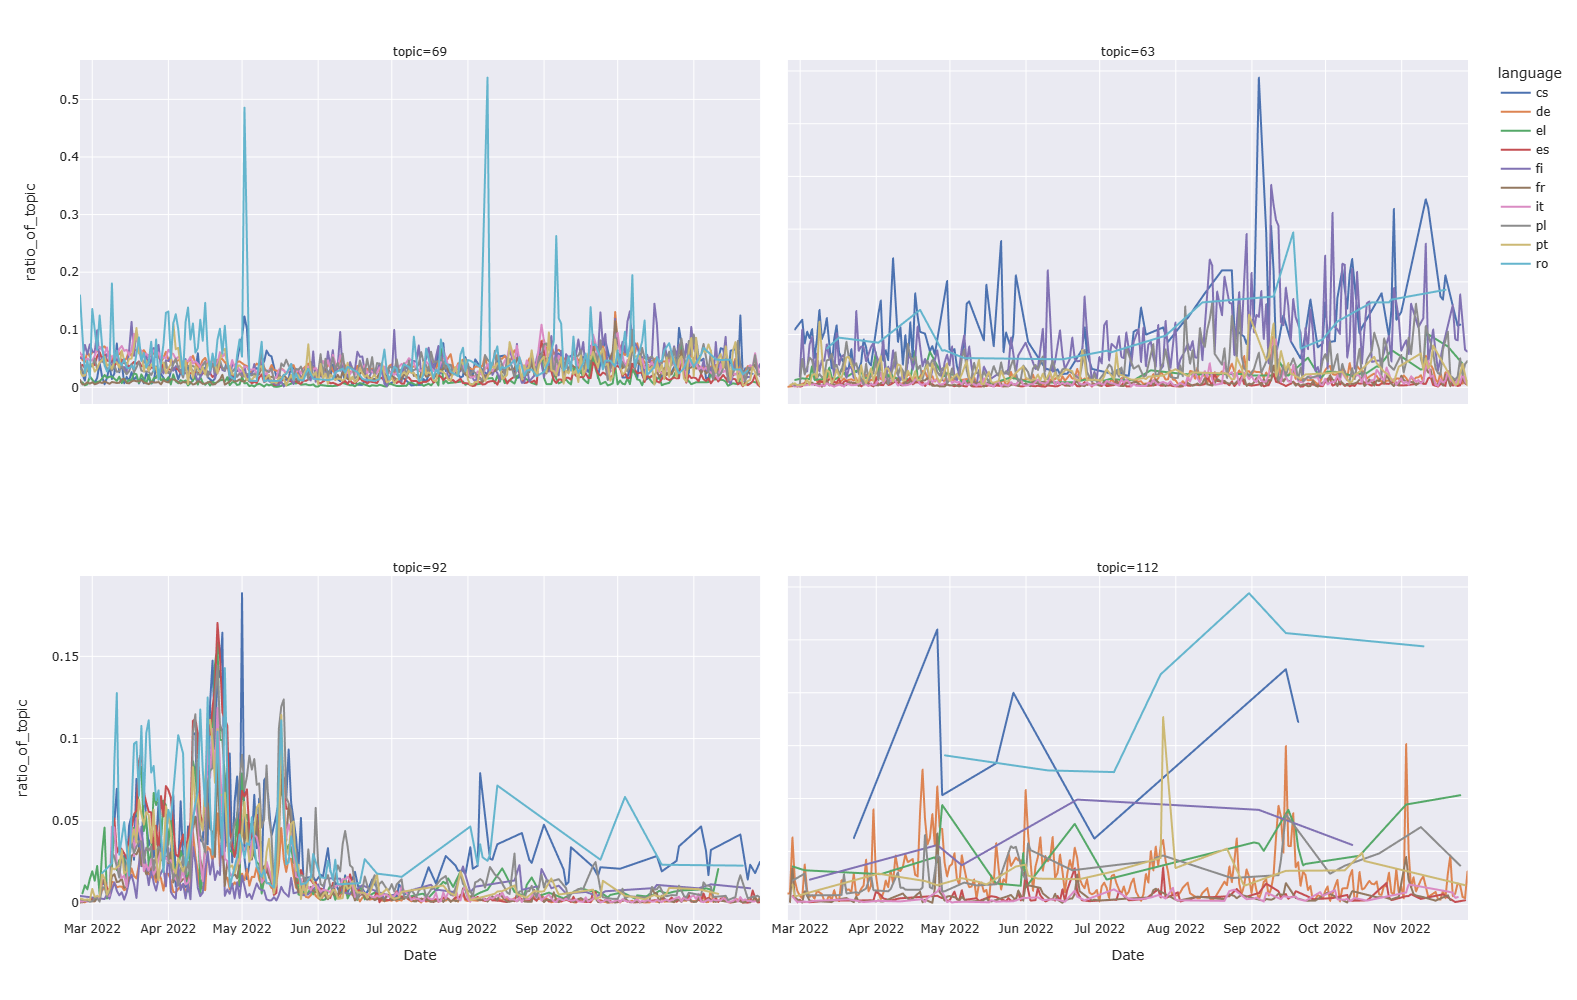

In [88]:
topics_final = [63, 69, 92, 112]
mask = df_tweet_bytopic_bylanguage.topic.isin(topics_final)
df_tweet_bytopic_bylanguage = df_tweet_bytopic_bylanguage[mask]

warnings.filterwarnings('ignore')
#https://plotly.com/python/facet-plots/
fig = px.line(df_tweet_bytopic_bylanguage,
              x='Date',
              y='ratio_of_topic',
              color='language',
              facet_col='topic',
              facet_col_wrap=2,
              facet_row_spacing=0.2,
              width=1000,
              height=1000,
              template='seaborn',
             )

fig.update_yaxes(matches=None)
fig.write_html("./Plots/topic_facet_plot.html")
fig.show()